## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import load_model

## Download and explore the dataset

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Download the pokemon dataset
data_dir = pathlib.Path("/content/drive/MyDrive/project3/dataset")    # Update path to appropriate dataset here as needed

count = len(list(data_dir.glob('*/*.jpg')))
print(f'Image Count: {count}')

Image Count: 10118


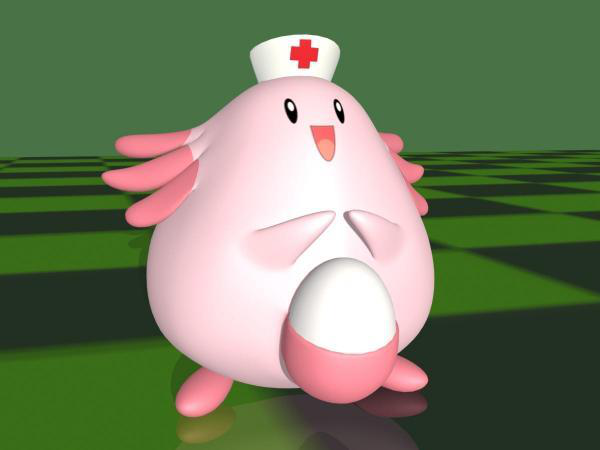

In [ ]:
Chansey = list(data_dir.glob('Chansey/*'))
PIL.Image.open(str(Chansey[10]))

## Create a dataset


In [ ]:
batch_size = 32         # The batch size defines the number of samples that will be propagated throught the network.  https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
img_height = 180
img_width = 180

In [ ]:
# 90% of the images for training, and 10% for validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10658 files belonging to 149 classes.
Using 9593 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10658 files belonging to 149 classes.
Using 1065 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Nidoqueen', 'Nidorina'

## Configure the dataset for performance

In [ ]:
#Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

#Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

#Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Preprocess the data

In [ ]:
#Data augmentation

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Create the model

In [ ]:
#Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

#When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. 
#Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. 
#This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

#Number of classes
num_classes = 149

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
# Compile model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)      

In [ ]:
# Assuming the goal of a training is to minimize the loss, the EarlyStoppping will stop training when a monitored metric has stopped improving.  
# For this project, we will be monitoring 'loss' and using the 'patience' variable to determine the right time to stop the training model to prevent us from overfitting the data.

tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

# This call back will stop the training when there is no more improvement in the validation loss for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
# Train model

max_epochs = 100              
                             
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=max_epochs,
  batch_size=batch_size,
  callbacks=[callback],
)


Epoch 1/100
300/300 [==============================] - 2151s 711ms/step - loss: 4.8393 - accuracy: 0.0589 - val_loss: 4.1686 - val_accuracy: 0.1070
Epoch 2/100
300/300 [==============================] - 7s 24ms/step - loss: 3.9989 - accuracy: 0.1326 - val_loss: 3.8339 - val_accuracy: 0.1324
Epoch 3/100
300/300 [==============================] - 7s 25ms/step - loss: 3.6536 - accuracy: 0.1710 - val_loss: 3.6336 - val_accuracy: 0.1653
Epoch 4/100
300/300 [==============================] - 7s 24ms/step - loss: 3.4570 - accuracy: 0.2042 - val_loss: 3.5218 - val_accuracy: 0.1934
Epoch 5/100
300/300 [==============================] - 7s 25ms/step - loss: 3.2380 - accuracy: 0.2379 - val_loss: 3.3303 - val_accuracy: 0.2225
Epoch 6/100
300/300 [==============================] - 7s 24ms/step - loss: 3.0748 - accuracy: 0.2642 - val_loss: 3.2249 - val_accuracy: 0.2507
Epoch 7/100
300/300 [==============================] - 7s 24ms/step - loss: 2.9161 - accuracy: 0.2930 - val_loss: 3.0905 - val_accur

In [ ]:
epoch_count = len(history.history['loss'])
epoch_count

87

In [ ]:
training_loss = history.history['loss'][epoch_count-1]
training_accuracy = history.history['accuracy'][epoch_count-1]
validation_loss = history.history['val_loss'][epoch_count-1]
validation_accuracy = history.history['val_accuracy'][epoch_count-1]

print(f'Training Loss: {training_loss}')
print(f'Training Accuracy: {training_accuracy}')
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_loss}')

Training Loss: 0.910364031791687
Training Accuracy: 0.7355363368988037
Validation Loss: 4.310637950897217
Validation Accuracy: 4.310637950897217


In [ ]:
print(history)

In [ ]:
# Keras provide the capability to register callbaacks when traiing a deep learning model.
# The history callback is a default callback that records training metrics for each epoch which includes the loss and accuracy for both the training and validation datasets.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Visualize training results
Create  plots of accuracy and loss on the training and validation sets.

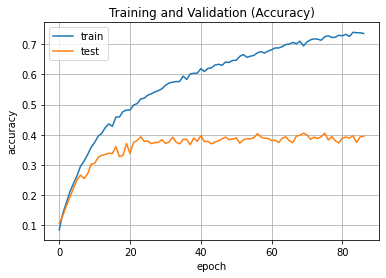

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'] )
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.title('Training and Validation (Accuracy)')
plt.savefig('/content/drive/MyDrive/project3/accuracy_v14.png', dpi=300, bbox_inches='tight')
plt.show()



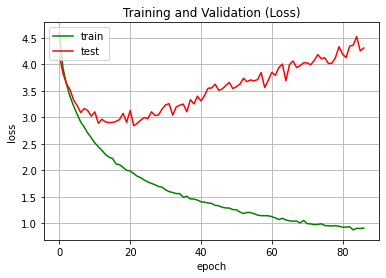

In [ ]:
# Summarize history for loss

plt.plot(history.history['loss'],color='green')
plt.plot(history.history['val_loss'], color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.title('Training and Validation (Loss)')
plt.savefig('/content/drive/MyDrive/project3/loss_v14.png', dpi=300, bbox_inches='tight')
plt.show()

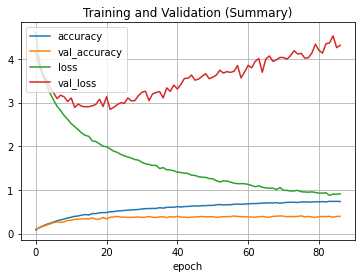

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'], loc='upper left')
plt.title('Training and Validation (Summary)')
plt.savefig('/content/drive/MyDrive/project3/combined_v14.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:

#test_path = '/content/drive/MyDrive/project3/image_dataset/Jigglypuff/2e8c1d1fd63c4995873c985cfaae9a1a.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Clefairy/6f2d93eccde941e6802ab22794646a5e.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Clefairy/30a9f1dac2834633904d5400ececb431.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Chansey/6855234d1b54464184d0fae220beeb2c.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Spearow/1f8662c6d570457fbef62312864f4d9d.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Spearow/3fad37fc00af41f8b50ab6d25970dd5e.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Wigglytuff/6b85e9f56e1e470689aff956c0f6e476.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Sandshrew/97ea7a736b3045eabc33098726ecb9d6.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Sandslash/960e49144a3542cc93340ccd287d8e0f.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Raticate/584a8a7d24f24e418bcd8ca2bbe2aafe.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Sandshrew/50fc676b907246868bad74ee1b7583ee.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Tauros/c578724eac054717ac413af2e8bf8b8f.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Tauros/43c02ca547d64069837366a61091d671.jpg'
#test_path = '/content/drive/MyDrive/project3/image_dataset/Tauros/43c02ca547d64069837366a61091d671.jpg'

##3D images
#test_path = '/content/drive/MyDrive/project3/test/pic_3d.jfif'
#test_path = '/content/drive/MyDrive/project3/test/pikachu3d.jfif'

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Clefairy with a 99.34 percent confidence.


## Save the model

In [ ]:
model.save("/content/drive/MyDrive/project3/pkmn_all_v14.h5")

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/project3/pkmn_all_v14.h5')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)      